In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#### Details of methodology

The dataset is passed to the dataloader as an array of filepaths. The labels are simply strings mapped to corresponding values.

run_fitting.py: ```
LABELS = {
            'neutral': 0,
            'somewhat NSFW': 1,
            'NSFW': 2
            }
            ```

In order to reduce the amount of data loaded into memory at a time, we allow the DataSet object to load images whenever the DataLoader calls them. This decreases the speed for each batch in SGD, however my system cannot load all of the images at one time. Images are therefore loaded whenever their indices are named instead of being loaded "eagerly" at the dataset instantiation.

Infrastructure.py:
```
def __getitem__(self, index:int) -> Tuple[torch.Tensor, str]:
        img = Image.open(self.X[index]).convert('RGB')
        return self.transform(img), self.y[index]
```

We then also split the data into Training, Test and Validation. "Validation" confirms the dataset accuracy at the end of fitting. The "Test" dataset is used to approximate loss at each epoch interval. Its size is intentionally made small since we need only to quickly calculate loss in order to tune the number of epochs. To this end, the model weights are only saved when validation at current epoch < minimum validation so far.

run_fitting.py:
```
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = TEST_SIZE )
X_test, X_val, y_test, y_val = train_test_split(X,y, test_size = 0.3)
```

We chose to use simple Cross Entropy Loss and the Adam optimizer to train a single classification per image and make use of our "smaller" dataset.

The neural net is then run for at least 20 epochs. Below are the results.

In [2]:
trends = pd.read_csv('./Scoring.txt')

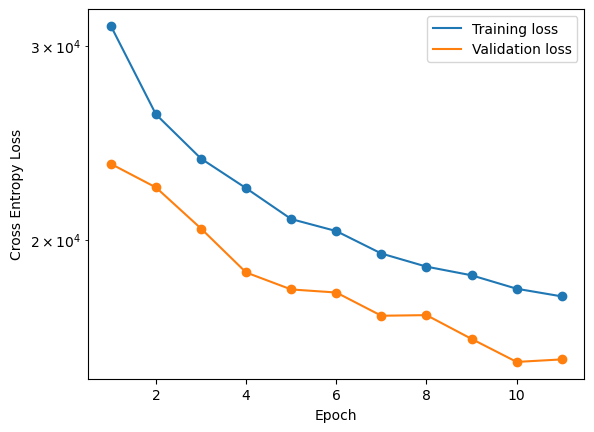

In [3]:
fig, ax = plt.subplots()

ax.plot(trends['Epoch'], trends[' Train Loss'], label = 'Training loss')
ax.plot(trends['Epoch'], trends[' Val Loss'], label = 'Validation loss')
ax.scatter(trends['Epoch'], trends[' Train Loss'], marker='o', zorder = 1)
ax.scatter(trends['Epoch'], trends[' Val Loss'], marker='o', zorder = 1)

ax.set_yscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Cross Entropy Loss')
ax.legend()

fig.savefig('ModelFitting.png')

As is evident, the loss continues to decrease with the number of epochs. This process is quite slow on my system and will take quite some time to fine-tune. Subsequent steps when this process is complete are the following:

- Calculation of a confusion matrix. This will allow us to determine the number of false negatives -- the metric we want to minimize most.
- Though we softmax our prediction vector when calculating loss, we can test the activation of the other output nodes with different sample images, to test the viability of using a threshold in the "somewhat NSFW" node to identify difficult-to-classify content.

We can preliminarily test this with a subset of the data:

In [4]:
import torch
from torch.utils.data import DataLoader
from Infrastructure import CaptchaDataset, ResNetWrapper
from pathlib import Path
from sklearn.model_selection import train_test_split

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np

In [9]:
LABELS = {
            'neutral': 0,
            'sexy': 1,
            'porn': 2
            }


DATA_DIR = './datascraper/data/train/'

directories = {
            'neutral': '%s/neutral/'%DATA_DIR,
            'sexy': '%s/sexy/'%DATA_DIR,
            'porn': '%s/porn/'%DATA_DIR,
            }


for label in directories:

    # Collect the files
    file_locations = [ img for img in Path(directories[label]).glob('*') ]

    # Just reassign directories vals to the glob
    directories[label] = file_locations


X = []
for label in directories:
    X+= directories[label]
y = []
for label in directories:
    y+= [LABELS[label]] * len(directories[label])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 1e-2)

# I accidentally forgot to rename this CaptchaDataset class & it's too late now -> "tech debt"
dataloader = DataLoader(CaptchaDataset(X_test,y_test), 
    64, shuffle=True, num_workers = 4)

net = ResNetWrapper()
statedict = torch.load('./ResNetWrapper_weights.pth', map_location = torch.device('cpu'))
# Honestly not sure why saving from outside wrapper changes the odict names
net.load_state_dict( { 'network.%s'%key : statedict[key] for key in statedict } 
    )

net.validate(dataloader)

INFO:root:562 labels scanned
INFO:root:Accuracy : 84.87544483985765%
INFO:root:Number of False Negatives: 80; as a pctg of all labels 38.095238095238095


0.8487544483985765

Our preliminary accuracy rests near 85%, with a 40% false negative rate. This is an improvement from the baseline (roughly 60%), or FNR >40%.